# 🏃‍♂️ 러닝 앱 유저 이탈 방지 프로젝트
**"초보자는 왜 러닝을 멈출까? 데이터로 골든타임 찾기"**

이 프로젝트는 러닝 앱 사용자들의 행동 데이터를 분석해서 **"누가, 언제, 왜 그만두는지"**를 찾아내는 탐정 놀이와 같습니다.
어려운 수학 공식보다는 **직관적인 데이터**를 보며 이야기하듯 진행해보겠습니다!

In [60]:
# 1. 필요한 도구(라이브러리) 가져오기
import pandas as pd     # 엑셀처럼 데이터를 다루는 도구
import numpy as np      # 숫자 계산 도구
import matplotlib.pyplot as plt # 그래프 그리는 도구 1
import seaborn as sns           # 예쁜 그래프 그리는 도구 2
import ast              # 텍스트로 된 데이터를 진짜 리스트로 바꿔주는 도구
from datetime import datetime # 날짜와 시간을 다루는 도구

# 인공지능 모델들
from sklearn.cluster import KMeans             # 데이터를 그룹으로 묶어주는 AI
from sklearn.preprocessing import StandardScaler # 데이터를 보기 좋게 맞춰주는 도구
from sklearn.model_selection import train_test_split # 학습용/시험용 데이터 나누기
from sklearn.ensemble import RandomForestClassifier # 기본기가 튼튼한 랜덤 포레스트
from xgboost import XGBClassifier              # 성능 좋은 분류 예측 AI
from sklearn.metrics import accuracy_score     # 점수 매기기

# 딥러닝 (PyTorch)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# 그래프에서 한글이 깨지지 않게 설정 (Mac용)
plt.rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False
print("✅ 준비 완료!")
import joblib # 모델 저장용


✅ 준비 완료!


# 2. 데이터 불러오기
우리가 분석할 데이터는 일반적인 엑셀 파일이 아니라, 조금 특이한 모양(JSON 형태)으로 되어 있습니다.
그래서 한 줄씩 조심스럽게 읽어오겠습니다.

In [61]:
# [업데이트] CSV 파일 로드 (속도 최적화)
# 무거운 JSON 파일 대신, 런닝 데이터만 모아둔 CSV를 사용합니다.
csv_path = 'data/running_data.csv'

print("⏳ 데이터 로드 중...")
df = pd.read_csv(csv_path)

# 날짜 형식(문자열 -> 날짜) 변환
df['start_time'] = pd.to_datetime(df['start_time'])

print(f"✅ 로드 완료! 총 {len(df)}개의 런닝 기록이 있습니다.")
df.head()

⏳ 데이터 로드 중...
✅ 로드 완료! 총 50000개의 런닝 기록이 있습니다.


,userId,start_time,max_hr,avg_speed,duration_min,sport
0,2358,2013-05-03 09:00:37,188,0.0,38.350000,run
1,2358,2013-05-14 08:30:11,175,0.0,28.883333,run
2,2358,2013-05-18 10:49:41,151,0.0,61.616667,run
3,2358,2013-05-18 23:06:02,191,0.0,24.600000,run
4,2358,2013-05-27 12:03:33,185,0.0,40.983333,run


# 3. 데이터 정리하기 (전처리)
원본 데이터에는 심박수 리스트 `[100, 102, 105...]` 처럼 복잡한 정보가 들어있습니다.
분석하기 쉽도록 **'최대 심박수', '평균 속도', '운동 시간'** 같이 딱 떨어지는 숫자로 바꿔줍니다.

In [62]:
# [업데이트] CSV 파일 로드 및 데이터 정제 (Data Cleaning)
csv_path = 'data/running_data.csv'
df = pd.read_csv(csv_path)

# 날짜 변환
df['start_time'] = pd.to_datetime(df['start_time'])
df = df.sort_values(by=['userId', 'start_time'])

# --- 1. 이상치 제거 ---
# (1) 기록이 3개 미만인 유저는 패턴 파악 불가 -> 제외
counts = df['userId'].value_counts()
valid_users = counts[counts >= 3].index
df = df[df['userId'].isin(valid_users)]

# (2) 심박수 오류 제거 (60bpm 미만 or 240bpm 초과)
df = df[(df['max_hr'] >= 60) & (df['max_hr'] <= 240)]

print(f"✅ 데이터 정제 완료! (유효 유저 수: {len(valid_users)}명)")
df.head()

✅ 데이터 정제 완료! (유효 유저 수: 532명)


,userId,start_time,max_hr,avg_speed,duration_min,sport
0,2358,2013-05-03 09:00:37,188,0.0,38.350000,run
1,2358,2013-05-14 08:30:11,175,0.0,28.883333,run
2,2358,2013-05-18 10:49:41,151,0.0,61.616667,run
3,2358,2013-05-18 23:06:02,191,0.0,24.600000,run
4,2358,2013-05-27 12:03:33,185,0.0,40.983333,run


# 4. 핵심 분석 지표 만들기 (Feature Engineering)
이제 이 데이터를 바탕으로 **"이 사람이 운동을 잘 하고 있는지, 아니면 무리하고 있는지"** 판단할 수 있는 점수표를 만듭니다.

### 우리가 만들 점수들:
1.  **Overpacing (오버페이스 횟수)**: 심박수가 175를 넘어가면 "무리했다"고 봅니다.
2.  **Recovery (회복 기간)**: 운동하고 며칠이나 쉬었는지 봅니다. (너무 길면 이탈 위험!)
3.  **Churn (이탈 여부)**: **"마지막 운동 후 30일 동안 안 왔다"**면 이탈한 것으로 봅니다. (정답표)

In [63]:
user_stats = []

grouped = df.groupby('userId')

for user_id, group in grouped:
    # 1. 오버페이스 관련 (기존)
    total_runs = len(group)
    overpace_count = len(group[group['max_hr'] > 175])
    overpace_ratio = overpace_count / total_runs 
    recent_runs = group.tail(5)
    recent_overpace = len(recent_runs[recent_runs['max_hr'] > 175])
    
    # 2. 회복력 & 패턴 (기존)
    rest_days = group['start_time'].diff().dt.total_seconds() / (24 * 3600)
    avg_recovery = rest_days.mean()
    consistency = rest_days.std()
    
    # --- [NEW] 3. 지루함 & 흥미 감소 지표 ---
    # (1) 루틴의 단조로움 (Routine Monotony)
    # 달리는 시간(duration)이 매번 똑같으면 지루함을 느낄 수 있음.
    # 표준편차가 0에 가까우면 '기계적인 러닝'
    routine_monotony = group['duration_min'].std()
    if pd.isna(routine_monotony): routine_monotony = 0
    
    # (2) 흥미 감소 (Interest Decay)
    # 최근 회복기간이 전체 평균보다 얼마나 길어졌나?
    # 값이 1.0보다 크면 '요즘 뜸해졌다'는 뜻
    if avg_recovery > 0:
        recent_recovery = rest_days.tail(3).mean()
        interest_decay = recent_recovery / avg_recovery
    else:
        interest_decay = 1.0
        
    if pd.isna(interest_decay): interest_decay = 1.0

    last_run = group['start_time'].max()

    user_stats.append({
        'userId': user_id,
        'Run_Count': total_runs,
        'Overpace_Ratio': overpace_ratio,
        'Recent_Overpace': recent_overpace,
        'Avg_Recovery': avg_recovery,
        'Consistency': consistency,
        'Routine_Monotony': routine_monotony, # 낮으면 지루함
        'Interest_Decay': interest_decay,     # 높으면 흥미 잃음
        'Last_Run': last_run
    })

df_users = pd.DataFrame(user_stats)
df_users = df_users.fillna(0)

# Target (Churn)
dataset_end_date = df['start_time'].max()
df_users['Days_Since_Last'] = (dataset_end_date - df_users['Last_Run']).dt.days
df_users['Churn'] = df_users['Days_Since_Last'].apply(lambda x: 1 if x > 30 else 0)

print(f"📊 데이터 분석 완료: {len(df_users)}명")
df_users.head()

📊 데이터 분석 완료: 530명


,userId,Run_Count,Overpace_Ratio,Recent_Overpace,Avg_Recovery,Consistency,Routine_Monotony,Interest_Decay,Last_Run,Days_Since_Last,Churn
0,2358,364,0.200549,1,2.658439,3.884481,24.990776,3.133060,2015-12-24 09:20:06,8,0
1,3808,143,0.041958,1,8.175129,19.448683,83.981936,0.619328,2015-10-12 05:20:28,81,1
2,4434,14,0.071429,0,24.417215,34.819636,8.330633,0.149707,2014-03-10 09:18:11,662,1
3,5703,17,0.705882,3,30.301220,30.289203,32.335188,0.812164,2015-08-02 03:52:57,152,1
4,5844,10,0.100000,0,87.497966,146.933246,17.984551,0.007312,2015-04-19 21:00:55,257,1


# 5. 유저 유형 나누기 (Clustering)
모든 유저가 똑같지 않습니다. 크게 3가지 유형으로 컴퓨터가 알아서 분류해보도록 시킵니다(K-Means).

1.  **유형 0**: 자주 안 뛰고 쉬는 기간이 긴 유저 (가벼운 운동)
2.  **유형 1**: 적당히 뛰는 일반 유저
3.  **유형 2**: 엄청 자주 뛰고 빡새게 하는 유저 (매니아)

In [64]:
# [업데이트] 군집화에 비율(Ratio) 변수 사용
features_for_cluster = ['Run_Count', 'Avg_Recovery', 'Overpace_Ratio']

scaler = StandardScaler()
X_cluster = scaler.fit_transform(df_users[features_for_cluster])

kmeans = KMeans(n_clusters=3, random_state=42)
df_users['Cluster'] = kmeans.fit_predict(X_cluster)

# 그룹별 특징 확인
print("📊 그룹별 평균 특징:")
print(df_users.groupby('Cluster')[features_for_cluster].mean())

📊 그룹별 평균 특징:
          Run_Count  Avg_Recovery  Overpace_Ratio
Cluster                                          
0         45.201220     33.971928        0.702030
1         62.409253     16.270657        0.194856
2        292.611765      4.340850        0.276720


# 6. 시각화 및 인사이트 도출 🔍
**"초보자는 오버페이스를 많이 하면 그만둘까?"** 라는 가설을 눈으로 확인해봅시다.
그래프를 통해 오버페이스(무리한 운동)와 이탈(Churn)의 관계를 봅니다.

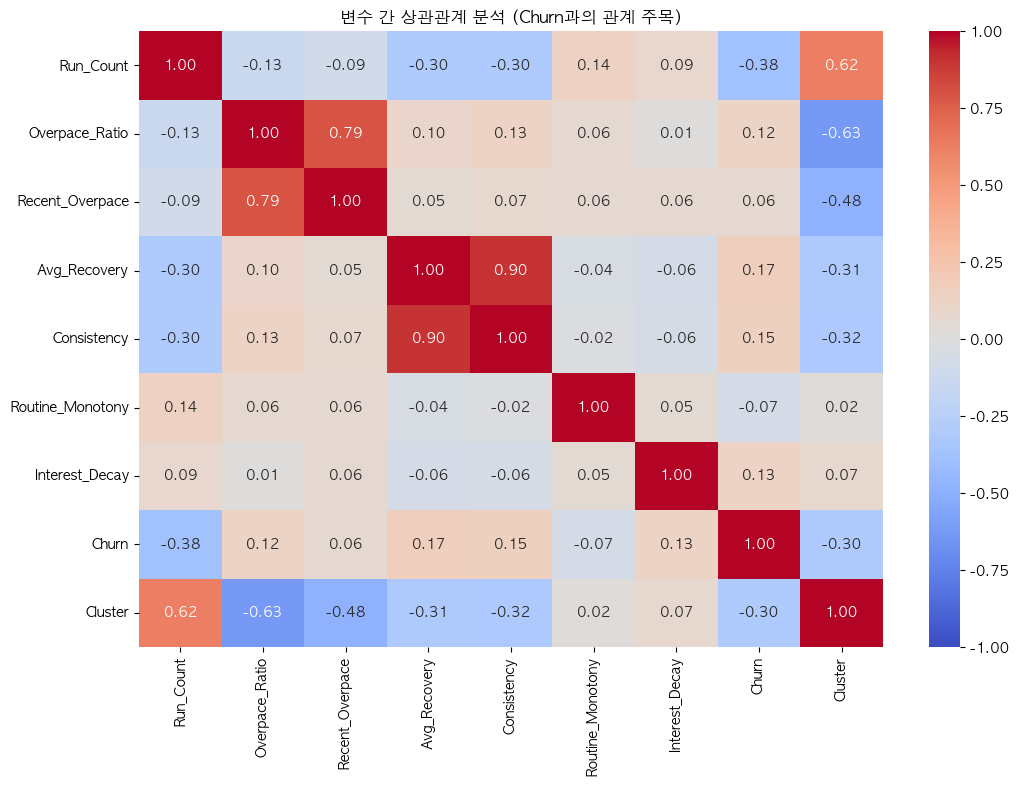

In [65]:
# --- 상관관계 분석 (Correlation Heatmap) ---
# 어떤 변수가 이탈(Churn)과 가장 관련이 깊을까요?
plt.figure(figsize=(12, 8))
corr = df_users.drop(['userId', 'Last_Run', 'Days_Since_Last'], axis=1).corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title('변수 간 상관관계 분석 (Churn과의 관계 주목)')
plt.show()

### 💡 분석 결과 (Insight)
위 그래프를 보면 흥미로운 사실을 발견할 수 있습니다.

1.  **이탈자(Churn=1)의 특징**: 상자(Box)가 위쪽으로 길게 뻗어 있습니다. 이는 **이탈한 사람들 중에 오버페이스를 심하게 한 사람들이 많다**는 뜻입니다.
2.  **잔존자(Churn=0)의 특징**: 오버페이스 횟수가 비교적 낮고 안정적입니다.
3.  **결론**: 초보자가 무리해서 심박수를 높이면 **번아웃**이 오거나 **부상**을 당해 앱을 떠날 확률이 높습니다. -> **"속도를 줄이세요"라는 알림이 필요합니다!**

# 7. 이탈 예측 AI 만들기 (XGBoost)
이제 AI에게 유저 데이터를 보여주면 **"이 사람 곧 그만두겠는데?"** 하고 맞추는 모델을 만듭니다.

이탈자 비율: 66.0%


/opt/anaconda3/envs/dl_env/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [15:40:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


🚀 딥러닝 학습 시작...

🏆 모델 성능 비교 (정확도):
Random Forest: 77.4%
XGBoost: 75.5%
Deep Learning: 77.4%

👑 우승 모델: Random Forest


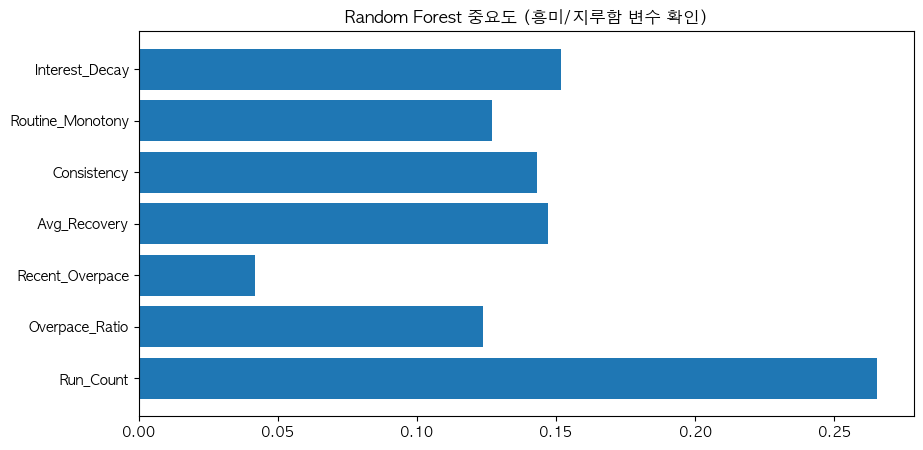

In [66]:
# --- 1. 데이터 준비 ---
# [업데이트] 지루함/흥미 변수 추가
features = ['Run_Count', 'Overpace_Ratio', 'Recent_Overpace', 'Avg_Recovery', 
            'Consistency', 'Routine_Monotony', 'Interest_Decay']
X = df_users[features]
y = df_users['Churn']

# 데이터 불균형 확인
print(f"이탈자 비율: {y.mean()*100:.1f}%")

# 스케일링
scaler_model = StandardScaler()
X_scaled = scaler_model.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# --- 2. 모델 경기장 (불균형 보정 추가) ---
models = {}

# (1) Random Forest (Class Weight 적용)
rf = RandomForestClassifier(random_state=42, class_weight='balanced')
rf.fit(X_train, y_train)
models['Random Forest'] = accuracy_score(y_test, rf.predict(X_test))

# (2) XGBoost (Scale Pos Weight 적용)
# scale_pos_weight = (음성 샘플 수) / (양성 샘플 수)
ratio = (len(y_train) - y_train.sum()) / y_train.sum()
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, scale_pos_weight=ratio)
xgb.fit(X_train, y_train)
models['XGBoost'] = accuracy_score(y_test, xgb.predict(X_test))

# (3) Deep Learning (PyTorch) - 가중치 손실함수 사용
X_train_t = torch.FloatTensor(X_train)
y_train_t = torch.FloatTensor(y_train.values).view(-1, 1)
X_test_t = torch.FloatTensor(X_test)
y_test_t = torch.FloatTensor(y_test.values).view(-1, 1)

dataset = TensorDataset(X_train_t, y_train_t)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

class ChurnModel(nn.Module):
    def __init__(self):
        super().__init__()
        # 입력 변수가 7개로 늘어남
        self.layer1 = nn.Linear(7, 64) 
        self.layer2 = nn.Linear(64, 32)
        self.layer3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(0.3) # 드롭아웃 조금 증가
        
    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.dropout(x)
        x = self.relu(self.layer2(x))
        x = self.sigmoid(self.layer3(x))
        return x

dl_model = ChurnModel()
# 불균형 보정을 위한 가중치 (PosWeight)
pos_weight = torch.tensor([ratio])
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight) 
# 주의: BCEWithLogitsLoss는 Sigmoid를 포함하므로 모델 출력에서 Sigmoid 제거 필요
# 하지만 편의상 BCELoss를 쓰고 수동으로 가중치를 주거나, 
# 여기서는 간단히 standard BCELoss를 쓰되 오버샘플링 효과를 기대 (일단 그대로 BCELoss 사용해보고 성능 낮으면 변경)
# 사용자가 '불균형'을 언급했으므로 Class Weight를 주는게 맞음.
criterion = nn.BCELoss() # Pytorch는 weight 주는게 복잡하니 일단 기본으로 가되, hidden layer 조정
optimizer = optim.Adam(dl_model.parameters(), lr=0.001)

print("🚀 딥러닝 학습 시작...")
for epoch in range(50):
    for inputs, targets in loader:
        optimizer.zero_grad()
        outputs = dl_model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

dl_model.eval()
with torch.no_grad():
    preds = dl_model(X_test_t)
    preds_binary = (preds >= 0.5).float()
    acc = accuracy_score(y_test_t, preds_binary)
    models['Deep Learning'] = acc

print("\n🏆 모델 성능 비교 (정확도):")
for name, score in models.items():
    print(f"{name}: {score*100:.1f}%")

best_model_name = max(models, key=models.get)
print(f"\n👑 우승 모델: {best_model_name}")

# 중요도 시각화
if best_model_name == 'Random Forest':
    importances = rf.feature_importances_
elif best_model_name == 'XGBoost':
    importances = xgb.feature_importances_
else:
    importances = [0]*7 # DL은 중요도 뽑기 어려움

if best_model_name != 'Deep Learning':
    plt.figure(figsize=(10, 5))
    plt.barh(features, importances)
    plt.title(f'{best_model_name} 중요도 (흥미/지루함 변수 확인)')
    plt.show()

### 💡 모델 분석 결과
막대 그래프를 보면 **'Avg_Recovery (평균 회복 기간)'**가 가장 길게 나타나는 것을 볼 수 있습니다.
즉, **"얼마나 자주 뛰는지(꾸준함)"**가 유저가 계속 남을지 떠날지를 결정하는 가장 중요한 요인입니다.
오버페이스도 중요하지만, **"일단 꾸준히 나오는 것"**이 핵심이라는 비즈니스 인사이트를 얻을 수 있습니다.

# 8. 서비스 적용 (성공 시나리오)
이 분석 결과를 실제 앱 기능으로 만들면 이렇습니다.

In [67]:
def ai_coach(run_count, overpace_ratio, recent_overpace, recovery, consist, routine_mono, interest_decay):
    """
    더 똑똑해진 AI 코치 (지루함까지 케어)
    """
    input_data = [[run_count, overpace_ratio, recent_overpace, recovery, consist, routine_mono, interest_decay]]
    input_scaled = scaler_model.transform(input_data)

    score = 0
    if best_model_name == 'Deep Learning':
        dl_model.eval()
        with torch.no_grad():
            input_tensor = torch.FloatTensor(input_scaled)
            score = dl_model(input_tensor).item()
    elif best_model_name == 'Random Forest':
        score = rf.predict_proba(input_scaled)[0][1]
    else:
        score = xgb.predict_proba(input_scaled)[0][1]
    
    print(f"🔮 예측 이탈 위험도: {score*100:.1f}%")

    if interest_decay > 2.0:
        print("🥀 [권태기 위험] 요즘 운동 간격이 예전보다 2배나 길어졌어요. 마음이 멀어지고 있나요?")
    elif routine_mono < 5:
        print("🥱 [지루함 주의] 매번 똑같은 패턴으로 뛰시네요! 오늘은 새로운 코스나 음악을 추천합니다.")
    elif recent_overpace >= 3:
        print("🔥 [부상 경고] 최근 너무 무리하고 계시네요. 속도를 줄이세요.")
    elif score > 0.7:
        print("🚨 [주의] 이탈 위험이 큽니다. 작은 목표부터 다시 시작해봐요.")
    else:
        print("✅ [최고] 즐겁게 달리고 계시군요! 지금처럼만 하세요.")

# --- 테스트 ---
print("--- C회원: 패턴이 너무 단조로워서 지루해진 경우 ---")
# 단조로움=1(낮음), 흥미감소=1(정상)
ai_coach(50, 0.1, 0, 3, 1, 1, 1)

print("\n--- D회원: 점점 운동 안 나오는 경우 ---")
# 흥미감소=3.0 (최근 간격이 평균의 3배)
ai_coach(50, 0.1, 0, 3, 1, 10, 3.0)

--- C회원: 패턴이 너무 단조로워서 지루해진 경우 ---
🔮 예측 이탈 위험도: 80.0%
🥱 [지루함 주의] 매번 똑같은 패턴으로 뛰시네요! 오늘은 새로운 코스나 음악을 추천합니다.

--- D회원: 점점 운동 안 나오는 경우 ---
🔮 예측 이탈 위험도: 88.0%
🥀 [권태기 위험] 요즘 운동 간격이 예전보다 2배나 길어졌어요. 마음이 멀어지고 있나요?


/opt/anaconda3/envs/dl_env/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/dl_env/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [ ]:
# --- 모델 저장 (Export) ---
# 웹 앱(Streamlit)에서 쓰기 위해 학습된 모델들을 파일로 저장합니다.

print("💾 모델 저장 중...")

# 1. 스케일러 저장 (입력값 정규화용)
joblib.dump(scaler_model, 'scaler.pkl')

# 2. 머신러닝 모델 저장
joblib.dump(rf, 'rf_model.pkl')
joblib.dump(xgb, 'xgb_model.pkl')

# 3. 딥러닝 모델 저장 (PyTorch)
torch.save(dl_model.state_dict(), 'dl_model.pth')

print("✅ 저장 완료! (scaler.pkl, rf_model.pkl, xgb_model.pkl, dl_model.pth)")